### Create dataset from Google Images
- Repeat steps for new categories.

In [1]:
from fastai.vision import *

## Get a list of URLs
### Search and scroll
- Get specific images from google to create classes
- Scroll to bottom
- use qoutes to include items and minus sign to exclude variants

### Download into file
- <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>J</kbd> in Mac: opens javascript console.
- URL for images: disable ad blocking extensions (uBlock, AdBlockPlus etc.). Otherwise window.open() coomand doesn't work.

- Code snippet: 
    - ```javascript
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

### Create directory and upload urls file into your server

Choose an appropriate name for your labeled images. You can run these steps multiple times to create different labels.

Below is a variety of different rocket ships and low orbit launchers. 

In [ ]:
folder = 'nasa'
file = 'nasa.csv'

In [ ]:
folder = 'origin'
file = 'origin.csv'

In [ ]:
folder = 'spacex'
file = 'spacex.csv'

In [ ]:
folder = 'strato'
file = 'strato.csv'

In [ ]:
folder = 'virgin'
file = 'virgin.csv'

In [2]:
path = Path('/Users/home/Documents/git_repos/fastai/course-v3/nbs/dl1/images/spaceships/')
# dest = path/folder
# dest.mkdir(parents=True, exist_ok=True)

In [3]:
path.ls()

[PosixPath('/Users/home/Documents/git_repos/fastai/course-v3/nbs/dl1/images/spaceships/strato'),
 PosixPath('/Users/home/Documents/git_repos/fastai/course-v3/nbs/dl1/images/spaceships/.ipynb_checkpoints'),
 PosixPath('/Users/home/Documents/git_repos/fastai/course-v3/nbs/dl1/images/spaceships/origin'),
 PosixPath('/Users/home/Documents/git_repos/fastai/course-v3/nbs/dl1/images/spaceships/virgin'),
 PosixPath('/Users/home/Documents/git_repos/fastai/course-v3/nbs/dl1/images/spaceships/spacex'),
 PosixPath('/Users/home/Documents/git_repos/fastai/course-v3/nbs/dl1/images/spaceships/nasa')]

## Download images
- Download images from respective urls.
- Fast.ai has a function; downloads and saves images that can be opened.
- Specify urls filename and destination folder.
- Run this line once for every category.

In [4]:
classes = ['nasa','origin', 'spacex', 'strato', 'virgin']

In [ ]:
download_images(path/file, dest, max_pics=200)

Remove images that can't be opened:

In [ ]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

## View data

In [5]:
np.random.seed(42) #Set seed to enable same images on train/test split
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [ ]:
# If data cleaned, run this cell instead of above
# np.random.seed(42)
# data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
#         ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

View pictures:

In [6]:
data.classes

['nasa', 'origin', 'spacex', 'strato', 'virgin']

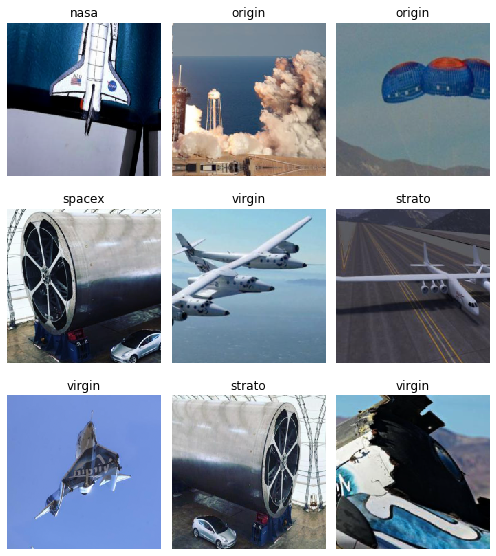

In [7]:
data.show_batch(rows=3, figsize=(7,8))

In [8]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['nasa', 'origin', 'spacex', 'strato', 'virgin'], 5, 749, 187)

## Train model

In [9]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [10]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.791802,1.082106,0.411765,02:06
1,1.391151,0.878671,0.352941,02:08
2,1.158242,0.854267,0.331551,02:16
3,1.014215,0.855369,0.336898,31:04


In [11]:
learn.save('stage-1') # Save the state of the machine(weights, parameters) for further experimentation

In [12]:
learn.unfreeze() 
# Unfreeze the entire model, so that we may tune earlier layers; in this czase created by transfer learning --  a pre-trained model.
# May be training different layer groups at different learning rates
# This is called discriminative layer training.

# Freeze, only trains on last layer. This allows us to leave our layers from our transfer learning model to remain untouched. 

In [13]:
learn.lr_find() # Find optimal learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


- As you can see the learning rate doesn't look very good. It looks like our model is getting worse over time. 

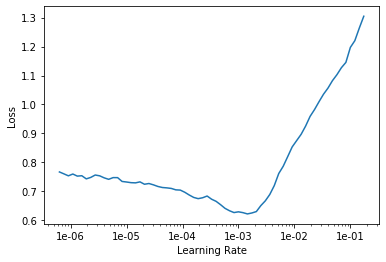

In [14]:
learn.recorder.plot() # learn.lr_find(start_lr=1e-5, end_lr=1e-1)learn.recorder.plot()

In [15]:
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.742078,0.885825,0.320856,03:01
1,0.633684,0.880826,0.320856,03:14


In [16]:
learn.save('stage-2')

## Interpretation

In [17]:
learn.load('stage-2');

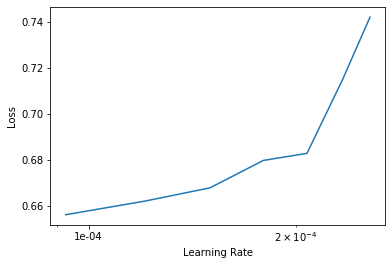

In [18]:
learn.recorder.plot()

In [19]:
interp = ClassificationInterpretation.from_learner(learn) # Shows which classes have the worst classification rate

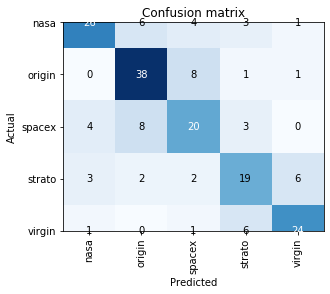

In [20]:
interp.plot_confusion_matrix()

## Cleaning Up
- Some top losses aren't due to bad performance. 
- There are images in our data set that shouldn't be.
- Using the `ImageCleaner` widget from `fastai.widgets` we can prune top losses, removing photos that don't belong.

In [21]:
from fastai.widgets import *

- Get file paths from top_losses: `.from_toplosses`
- Feed top losses indexes and corresponding dataset to `ImageCleaner`.
- Widget won't delete images directly, but creates new csv file `cleaned.csv`; from this create new ImageDataBunch with corrected labels to continue training.
- To clean entire set of images, create new dataset w/o split.

In [22]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch())

- If data already cleaned with: `from_toplosses` -- run this cell instead to remove duplicates.
- Otherwise all the results of the previous step would be overwritten by the new run of `ImageCleaner`.

In [23]:
# db = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
#                    .no_split()
#                    .label_from_df()
#                    .transform(get_transforms(), size=224)
#                    .databunch())

- Next create a new learner to use our new databunch with all images.

In [24]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [25]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)
# View top losses on cleaned data set
# If you run on Lab, you need to restart runtime; runtime state and all local variables will be lost.

- If there's problems: [link](https://github.com/fastai/fastai/issues/1539#issuecomment-505999861) to solve it.
- Flag photos for deletion, click 'Next Batch' to delete flagged photos.
- `ImageCleaner` shows new row of images until there are no more to show. 
- In this case, the widget will show you images until there are none left from `top_losses.ImageCleaner(ds, idxs)`

- To remove duplicates run `.from_similars`, then `ImageCleaner` with `duplicates=True`.
- Flag photos for deletion, click 'Next Batch' to delete flagged photos.

- Recreate databunch and `learn_cln` from the `cleaned.csv`. So we don't overwrite. 

In [26]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


In [27]:
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

## Production

- Export content of `Learner` object for production:

In [28]:
learn.export()

- Creates 'export.pkl' in directory that contains everything to deploy model (models, weights, and some metadata like  classes or the transforms/normalization used).

In [29]:
# test on cpu; defaults to cpu if no gpu
# defaults.device = torch.device('cpu')

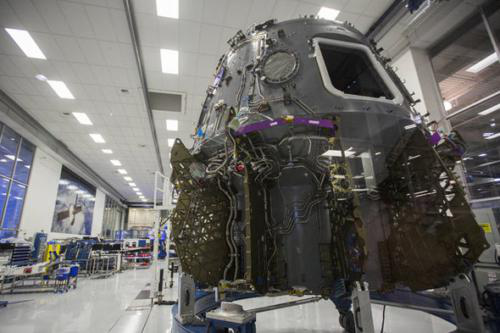

In [31]:
img = open_image(path/'nasa'/'nasa'/'00000000.jpg')
img

- Create `Learner` in production enviromnent, 
- Ensure `path` contains the file 'export.pkl' from before.

In [32]:
path

PosixPath('/Users/home/Documents/git_repos/fastai/course-v3/nbs/dl1/images/spaceships')

In [33]:
learn = load_learner(path)

In [34]:
pred_class, pred_idx, outputs = learn.predict(img)
pred_class

Category nasa

So you might create a route something like this ([thanks](https://github.com/simonw/cougar-or-not) to Simon Willison for the structure of this code):

```python
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })
```

(This example is for the [Starlette](https://www.starlette.io/) web app toolkit.)

## Things that can go wrong

- Most of the time things will train fine with the defaults
- There's not much you really need to tune (despite what you've heard!)
- Most likely are
  - Learning rate
  - Number of epochs

### Learning rate (LR) too high

In [46]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [ ]:
learn.fit_one_cycle(5, max_lr=0.0001)

epoch,train_loss,valid_loss,error_rate,time


### Learning rate (LR) too low

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Previously we had this result:

```
Total time: 00:57
epoch  train_loss  valid_loss  error_rate
1      1.030236    0.179226    0.028369    (00:14)
2      0.561508    0.055464    0.014184    (00:13)
3      0.396103    0.053801    0.014184    (00:13)
4      0.316883    0.050197    0.021277    (00:15)
```

In [ ]:
learn.fit_one_cycle(5, max_lr=1e-5)

In [ ]:
learn.recorder.plot_losses()

As well as taking a really long time, it's getting too many looks at each image, so may overfit.

### Too few epochs

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, pretrained=False)

In [ ]:
learn.fit_one_cycle(1)

### Too many epochs

In [ ]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.9, bs=32, 
        ds_tfms=get_transforms(do_flip=False, max_rotate=0, max_zoom=1, max_lighting=0, max_warp=0
                              ),size=224, num_workers=4).normalize(imagenet_stats)

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate, ps=0, wd=0)
learn.unfreeze()

In [ ]:
# learn.fit_one_cycle(40, slice(1e-6,1e-4))